In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
import pickle

In [368]:
# read data
biomarker_clean = pd.read_csv('../../data/biomarker_clean.csv')

In [369]:
# see column names
biomarker_clean.columns

Index(['Unnamed: 0', 'group', 'ados', 'CHIP', 'CEBPB', 'NSE', 'PIAS4',
       'IL-10 Ra', 'STAT3', 'IRF1',
       ...
       'UB2G2', 'Transgelin-2', 'ATPO', 'Corticotropin-lipotropin', 'QORL1',
       'PEDF', 'CATF', 'FTCD', 'UBP25', 'PLXB2'],
      dtype='object', length=1320)

In [370]:
# drop the unnamed column and ados
biomarker_clean = biomarker_clean.drop(['Unnamed: 0'], axis=1)

ADOS diagnostic algo- rithms consisting of two behavioral domains: Social Affect (SA) and Restricted and Repetitive Behaviors (RRB) were used to determine an ADOS total score, which provides a continuous measure of overall ASD symptom severity.

In [371]:
biomarker_clean[biomarker_clean['ados'].isna()]['group'].value_counts()

group
TD    78
Name: count, dtype: int64

In [372]:
biomarker_clean[biomarker_clean['ados'].notna()]['group'].value_counts()

group
ASD    76
Name: count, dtype: int64

# Binomial classification

In [373]:
biomarker_clean = biomarker_clean.drop(['ados'], axis=1)


In [374]:
biomarker_clean['group'] = biomarker_clean['group'].apply(lambda x: 1 if x == 'ASD' else 0).astype(int)

In [375]:
X = biomarker_clean.loc[:, 'CHIP':]
y = biomarker_clean.loc[:, 'group']

In [376]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sklearn.utils.resample(*arrays, replace=True, n_samples=None, random_state=None, stratify=None)[source]
Resample arrays or sparse matrices in a consistent way.

The default strategy implements one step of the bootstrapping procedure.

## Random Forest

In [377]:
# rf_model = RandomForestClassifier(n_estimators=100,
#                                   criterion='gini',
#                                   max_depth=15,
#                                   min_samples_split=5,
#                                   bootstrap=True,
#                                   random_state=197)
# rf_model.fit(X_train, y_train)
# rf_feature_importance = rf_model.feature_importances_

In [378]:
# rf_top_feature_importance_idx = np.argsort(rf_feature_importance)[-20:][::-1]
# rf_biomarker_clean = biomarker_clean.columns[rf_top_feature_importance_idx]
# rf_biomarker_clean

## Select top 20 proteins

In [379]:
# X_rf_top_20 = X_train.loc[:, rf_biomarker_clean]
# y_rf_top_20 = y_train
# lg_feature_importance = np.zeros(X_rf_top_20.shape[1]) # size = number of features

In [380]:
# for i in range(50):
#   X_bootstrap, y_bootstrap = resample(X_rf_top_20, y_rf_top_20, random_state=i)

#   lg_model = LogisticRegression(solver='liblinear', C=1, penalty='l1', random_state=i).fit(X_bootstrap, y_bootstrap)

#   lg_feature_importance += (lg_model.coef_ != 0).sum(axis=0) # sum over rows

# lg_feature_importance /= 50 # calculate the average of non-zero features


In [381]:
# unique_value, counts = np.unique(lg_feature_importance, return_counts=True)

In [382]:
# print(f'Average Non-zero coefficient frequency of appearance in bootsrap: {unique_value}')
# print(f'Counts of each average non-zero coefficient frequency: {counts}')

In [383]:
# feature_importance_top_9_idx = np.argsort(lg_feature_importance)[-9:][::-1] # select top 20 feature indices

# print(f'Top 20 Non-zero coefficient frequency INDEX of appearance in boot strap: {feature_importance_top_9_idx}')
# print(f'Top 20 Non-zero coefficient frequency VALUE of appearance in boot strap: {lg_feature_importance[feature_importance_top_9_idx]}')

## Correlation

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=198)

In [385]:
corr_matrix = X_train.corr()

high_corr_pairs = [
    (col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns if col1 != col2 and abs(corr_matrix.loc[col1, col2] > 0.9)
]

In [386]:
to_drop = set()

for col1, col2 in high_corr_pairs:
  if col1 not in to_drop and col2 not in to_drop:
    to_drop.add(col2)

In [387]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

## L1 Logistic Regression - Backwards Selection

In [388]:
# Initialize the model
log_reg_forward_model = LogisticRegression(solver='liblinear', random_state=197)

# Recursive Feature Elimination
rfe = RFE(estimator=log_reg_forward_model, n_features_to_select=20)
rfe.fit(X_train, y_train)

# Selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['FSTL1', 'HCE004152', 'MIA', 'IGFBP-1', 'Met', 'PIK3CA/PIK3R1',
       'b2-Microglobulin', 'HGFA', 'IL-6 sRa', 'PCSK7',
       'Coagulation Factor IX', 'IgD', 'DERM', 'ILT-4', 'RELT',
       'Semaphorin 3E', 'IL-17 RC', 'SRCN1', 'Epo', 'MIG'],
      dtype='object')


In [389]:
biomarker_rfe_top10_names = X_train.columns[np.argsort(rfe.ranking_)[:10]]

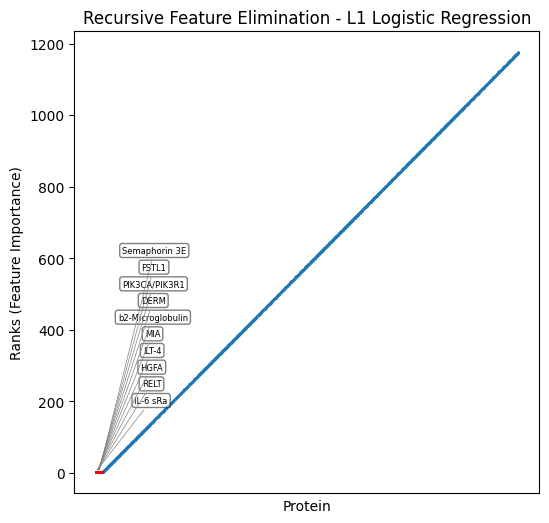

In [390]:
biomarker_rfe_top10_names = X_train.columns[np.argsort(rfe.ranking_)[:10]] # top 20 ranking importance names
biomarker_rfe_top10_y = np.sort(rfe.ranking_)[:20]
biomarker_rfe_top10_x = range(20)
offset_index = range(20)

ranking_sorted = np.sort(rfe.ranking_)

x_axis = range(X_train.shape[1])
y_axis = ranking_sorted

fig, ax = plt.subplots(figsize=[6, 6]);
plt.scatter(x=x_axis, y=y_axis, s=1);

for x, y, name, idx in zip(biomarker_rfe_top10_x, biomarker_rfe_top10_y, biomarker_rfe_top10_names, offset_index):
  ax.scatter(biomarker_rfe_top10_x, biomarker_rfe_top10_y, c='red', s=1);

  offset_x = 40 if idx <= 10 else None
  offset_y = (idx % 10) * 12 + 50

  ax.annotate(
    f'{name}' if idx <= 10 else None,
    (x, y),
    textcoords='offset points',
    xytext=(offset_x, offset_y),
    fontsize=6,
    ha='center',
    color='black',
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.5) if idx <= 10 else None,
    arrowprops=dict(arrowstyle='-', color='grey', linewidth=0.5) if idx <= 10 else None
  )

ax.set_xticks(ticks=());
ax.set_xlabel('Protein');
ax.set_ylabel('Ranks (Feature Importance)');
ax.set_title('Recursive Feature Elimination - L1 Logistic Regression')
  
plt.show();


# Random Forest - 5 Folds Cross Validation

In [391]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score


rf_model = RandomForestClassifier(n_estimators=100,
                                  criterion='gini',
                                  max_depth=15,
                                  min_samples_split=5,
                                  bootstrap=True,
                                  random_state=197)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=197)

feature_importance_rf = np.zeros(X_train.shape[1])

for train_idx, test_idx in kf.split(X_train, y_train):
  X_kf_train, X_kf_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
  y_kf_train, y_kf_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

  rf_model.fit(X_kf_train, y_kf_train)

  feature_importance_rf += rf_model.feature_importances_

  y_pred_prob = rf_model.predict_proba(X_kf_test)[:, 1]
  auc = roc_auc_score(y_kf_test, y_pred_prob)
  print({auc})

{np.float64(0.7948717948717949)}
{np.float64(0.75)}
{np.float64(0.717948717948718)}
{np.float64(0.8194444444444444)}
{np.float64(0.673611111111111)}


In [392]:
feature_importance_rf /= kf.get_n_splits()

feature_importance_df = pd.DataFrame({
  'Features': X_train.columns,
  'Importance': feature_importance_rf
})

top_20_features_rf = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
top_20_features_rf

,Features,Importance
962,ILT-4,0.014137
897,DERM,0.012502
873,IgD,0.010740
391,TNF sR-II,0.010178
255,Cadherin-5,0.007678
360,PTN,0.007294
611,CK-MB,0.006188
984,RELT,0.006156
586,DKK3,0.006035
711,MMP-2,0.005939


/var/folders/0n/rkp3_46s4kq642rgjzl4vzqh0000gn/T/ipykernel_12995/721433549.py:1: RuntimeWarning: divide by zero encountered in log
  fi_rf_sorted = np.log(np.sort(feature_importance_rf))
/var/folders/0n/rkp3_46s4kq642rgjzl4vzqh0000gn/T/ipykernel_12995/721433549.py:7: RuntimeWarning: divide by zero encountered in log
  label_y = np.log(np.sort(feature_importance_rf))[-20:][::-1];


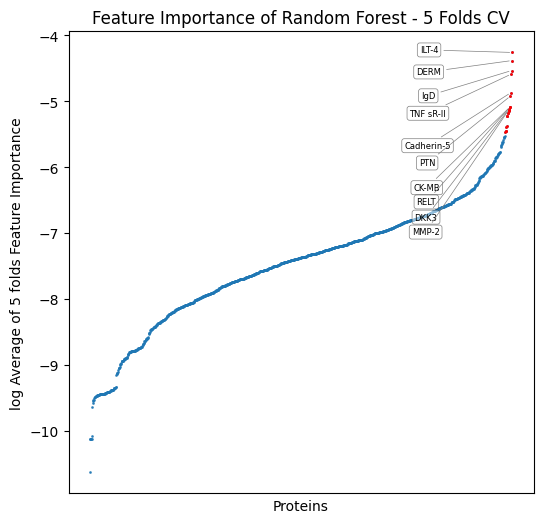

In [393]:
fi_rf_sorted = np.log(np.sort(feature_importance_rf))

fig, ax = plt.subplots(figsize=[6, 6])
ax.scatter(x=range(1194), y=fi_rf_sorted, s=1, alpha=0.8);

# biomarker_clean.columns[np.argsort(feature_importance_rf)[-20:]]
label_y = np.log(np.sort(feature_importance_rf))[-20:][::-1];
label_x = range(1194)[-20:][::-1]
biomarker_name = top_20_features_rf['Features'][-20:]
offsets_1 = range(20)[::-1]

for x, y, name, idx in zip(label_x, label_y, biomarker_name, offsets_1):
  offset_x = -60 if idx >= 10 else 0  # Labels for first 10 points to the left, next 10 to the right
  offset_y = (idx % 10) * 10 - 90     # Stagger labels vertically to prevent overlap

  ax.scatter(x, y, c='red', s=1);
  ax.annotate(
    f'{name}' if idx >= 10 else None,
    (x, y),
    textcoords='offset points',
    xytext=(offset_x, offset_y),
    ha='center',
    fontsize=6,
    color='black',
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', linewidth=0.5, alpha=0.5),
    arrowprops=dict(arrowstyle="-", color='gray', lw=0.5) if idx >= 10 else None
  )

ax.set_xticks(ticks=());
ax.set_xlabel('Proteins')
ax.set_ylabel('log Average of 5 folds Feature Importance')
ax.set_title('Feature Importance of Random Forest - 5 Folds CV')

plt.show();

In [394]:
# Find the overlapping features
overlapping_features = set(selected_features).union(top_20_features_rf.loc[:, 'Features'])

# Convert the result to a list if needed
overlapping_features = list(overlapping_features)

print("Overlapping features:", overlapping_features)

Overlapping features: ['MIG', 'M2-PK', 'IL-6 sRa', 'IgD', 'RELT', 'CDON', 'Gelsolin', 'SRCN1', 'Cadherin-5', 'IL-17 RC', 'MMP-2', 'Calcineurin', 'PCSK7', 'Semaphorin 3E', 'PIK3CA/PIK3R1', 'MIA', 'ILT-4', 'Epo', 'Notch 1', 'Coagulation Factor IX', 'TNF sR-II', 'CXCL16, soluble', 'IGFBP-1', 'Met', 'FSTL1', 'b2-Microglobulin', 'HCE004152', 'PTN', 'HGFA', 'aldolase A', 'CK-MB', 'DKK3', 'DERM', 'Aflatoxin B1 aldehyde reductase']


## Elastic Net Logistic Regression - Backwards Selection

In [395]:
# All features to be select
X_overlapping_features = X_train.loc[:, overlapping_features]

# Initialize the model
lg_model_eln = LogisticRegression(solver='saga', penalty='elasticnet',
                                  C=1.0, l1_ratio=0.5, random_state=197, max_iter=500)
# Forward Selection
sfs = RFE(estimator=lg_model_eln,
          n_features_to_select=6)

sfs.fit(X_overlapping_features, y_train)

# Selected features
selected_features = sfs.get_support(indices=True)

protein_panel_name = X_overlapping_features.columns[selected_features]
protein_panel_idx = selected_features
# X_overlapping_features.columns = range(len(X_overlapping_features.columns))
X_protein_panel = X_overlapping_features.iloc[:, selected_features]

In [396]:
# Initialize the model
lg_model_final = LogisticRegression(solver='liblinear', random_state=197, max_iter=500).fit(X_protein_panel, y_train)


In [397]:
cm = confusion_matrix(y_test, lg_model_final.predict(X_test.loc[:, protein_panel_name]))
np.savetxt('../../data/confusion_matrix.csv', cm, delimiter=',', fmt='%d')

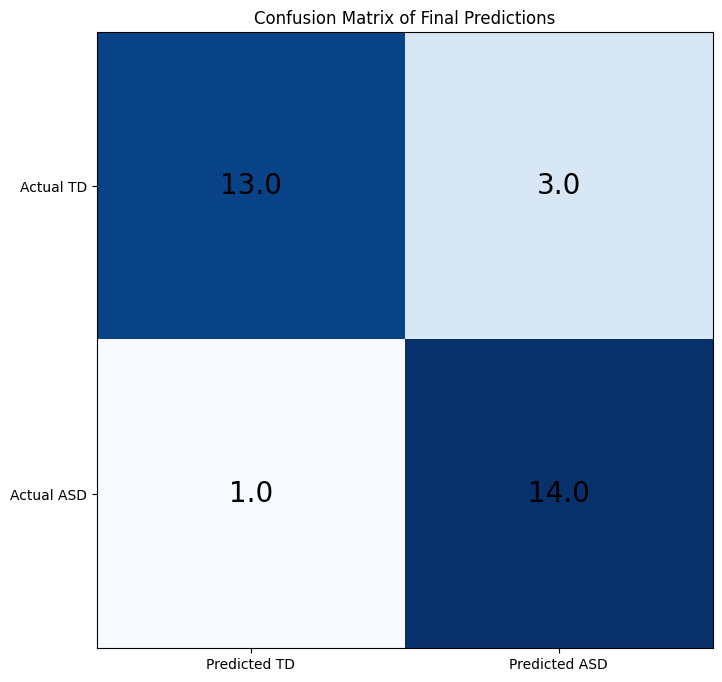

In [398]:
cm = np.loadtxt('../../data/confusion_matrix.csv', delimiter=',')
fig, ax = plt.subplots(figsize=[8, 8])
ax.imshow(cm, cmap="Blues")
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted TD', 'Predicted ASD'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual TD', 'Actual ASD'))
for i in range(2):
  for j in range(2):
    ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontdict={'fontsize': 20})
ax.grid(False)
ax.set_title('Confusion Matrix of Final Predictions')
plt.show();



In [399]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, lg_model_final.predict(X_test.loc[:, protein_panel_name])))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.82      0.93      0.88        15

    accuracy                           0.87        31
   macro avg       0.88      0.87      0.87        31
weighted avg       0.88      0.87      0.87        31



In [400]:
roc_auc_score(y_test, lg_model_final.predict(X_test.loc[:, protein_panel_name]))

np.float64(0.8729166666666667)

# Final Protein

In [401]:
protein_panel_name

Index(['IL-6 sRa', 'IgD', 'SRCN1', 'IL-17 RC', 'Coagulation Factor IX',
       'FSTL1'],
      dtype='object')

In [409]:
# Filter out non-pickleable objects
q4_variables = {
  'biomarker_rfe_top10_x': biomarker_rfe_top10_x, 
  'biomarker_rfe_top10_y': biomarker_rfe_top10_y, 
  'biomarker_rfe_top10_names': biomarker_rfe_top10_names, 
  'offset_index': offset_index,
  'ranking_sorted': ranking_sorted,
  'x_axis': x_axis,
  'y_axis': y_axis,
  'label_x': label_x, 
  'label_y': label_y, 
  'biomarker_name': biomarker_name, 
  'offsets_1': offsets_1,
  'fi_rf_sorted': fi_rf_sorted
}
with open('../../data/q4_variables.pkl', 'wb') as f:
  pickle.dump(q4_variables, f)
